In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

%matplotlib inline

In [2]:
df = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter='\t', header=None)

df.columns = ['review', 'score']
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.replace('.', ' ')
df['review'] = df['review'].str.replace(',', ' ')
df['review'] = df['review'].str.replace('!', ' ')

from nltk.corpus import stopwords
stop = stopwords.words('english')

words = df['review'].str.split().apply(lambda x: [item for item in x if item not in stop])

#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df['score'] = (df['score'] == 0)

In [3]:
np.sum(df['score']==True)/np.sum(df['score']==False)

1.0

This indicates that there is no class imbalace since there are an equal number of good and bad reviews and there is not a significant difference between one or the other. 

In [4]:
df.head()

,review,score
0,wow loved this place,False
1,crust is not good,True
2,not tasty and the texture was just nasty,True
3,stopped by during the late may bank holiday of...,False
4,the selection on the menu was great and so wer...,False


In [5]:
bad = np.where(df['score'] == True)
good = np.where(df['score'] == False)

In [6]:
from collections import Counter 

n = 150

Counter_bad = Counter(np.concatenate(np.asanyarray((words.iloc[bad])))) 
  
# most_common() produces n frequently encountered 
# input values and their respective counts. 
most_occur_bad = np.asanyarray(Counter_bad.most_common(n))
bad_words = most_occur_bad[:,0]


Counter_good = Counter(np.concatenate(np.asanyarray((words.iloc[good])))) 
most_occur_good = np.asanyarray(Counter_good.most_common(n))
good_words = most_occur_good[:,0]

In [7]:
keywords = []

for i in bad_words:
    dup_found = False
    for j in good_words:
        if i == j:
            dup_found = True
    if not dup_found:
        keywords.append(i)

In [8]:
#chose these keywords based off of words that you might find most likely to be in a bad yelp review
for key in keywords:
    df[str(key)] = df.review.str.contains(str(key), case=False)

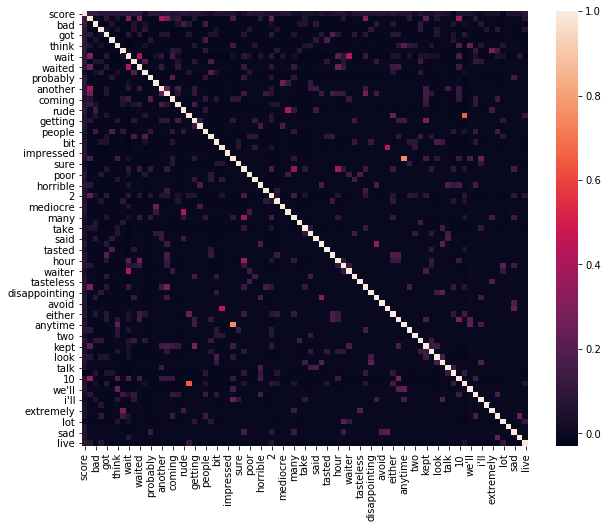

In [9]:
#making sure that my features are relatively independent of eachother.
plt.figure(figsize = (10,8))
sns.heatmap(df.corr())

plt.show()

In [10]:
#training data
data = df[keywords]
target = df['score']

In [11]:
#since the data is binary, import Bernoulli class
from sklearn.naive_bayes import BernoulliNB

#instantiate our model and store it in a new variable
bnb = BernoulliNB()

#fit model to data
bnb.fit(data, target)

#classify, storing the result in a new variable
y_pred = bnb.predict(data)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data.shape[0], (target != y_pred).sum()))

print('{}% mislabeled'.format((target != y_pred).sum()/data.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data.shape[0], 
    (target == y_pred).sum()
))

print('Accuracy = {:.4}%'.format((target == y_pred).sum()/data.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, y_pred)
false_pos = mat[1][0]
false_neg = mat[0][1]
specificity = mat[0][0]/sum(mat[0])
sensitivity = mat[1][1]/sum(mat[1])

print('confustion matrix: \n {}'.format(mat))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 1000 points : 244
24.4% mislabeled
Number of correctly identified points out of a total 1000 points : 756
Accuracy = 75.6%
confustion matrix: 
 [[463  37]
 [207 293]]
false positives: 207
false negatives: 37
sensitivity: 58.6%
specificity: 92.6%


In [17]:
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(bnb, data, target, cv=3)

print(cross_validation)
print('mean: {}%'.format(np.mean(cross_validation)*100))
print('standard deviation: {}%'.format(np.std(cross_validation)*100))

[0.73053892 0.69760479 0.71686747]
mean: 71.50037274847895%
standard deviation: 1.3509735010851969%


In [13]:
# Implement your own cross validation with your spam model.
def cross_validation(fit, data, target, k):
    from sklearn.metrics import confusion_matrix

    #fit = bnb
    #k = number of folds - must be a value that allows equal split
    
    rand_data = data.sample(frac=1)
    n_data = np.split(rand_data, indices_or_sections=k)
    
    vals = []
    matrices = []
    
    for i in range(len(n_data)):
        index = n_data[i].index
        
        test_data = data.drop(index, axis=0)
        test_target = target.drop(index, axis=0)
        vals.append(bnb.fit(test_data, test_target).score(n_data[i], target[index]))
        
        y_pred = bnb.predict(n_data[i])
        matrices.append(confusion_matrix(target[index], y_pred))
        
    return vals, matrices

In [14]:
k = 10
cross_val = cross_validation(bnb, data, target, k)

print(cross_val[0])
print('mean: {}%'.format(np.mean(cross_val[0])*100))
print('standard deviation: {}%'.format(np.std(cross_val[0])*100))

for i in range(k):
    mat = cross_val[1][i]
    false_pos = mat[1][0]
    false_neg = mat[0][1]
    specificity = mat[0][0]/sum(mat[0])
    sensitivity = mat[1][1]/sum(mat[1])
    
    print('k = {}'.format(i))
    print('accuracy: {}%'.format(cross_val[0][i]*100))
    print('confustion matrix: \n {}'.format(mat))
    print('false positives: {}'.format(false_pos))
    print('false negatives: {}'.format(false_neg))
    print('sensitivity: {:.4}%'.format(sensitivity*100))
    print('specificity: {:.4}%'.format(specificity*100))
    print('\n')

[0.71, 0.71, 0.66, 0.69, 0.69, 0.75, 0.7, 0.74, 0.73, 0.79]
mean: 71.7%
standard deviation: 3.4942810419312313%
k = 0
accuracy: 71.0%
confustion matrix: 
 [[49  4]
 [25 22]]
false positives: 25
false negatives: 4
sensitivity: 46.81%
specificity: 92.45%


k = 1
accuracy: 71.0%
confustion matrix: 
 [[38  5]
 [24 33]]
false positives: 24
false negatives: 5
sensitivity: 57.89%
specificity: 88.37%


k = 2
accuracy: 66.0%
confustion matrix: 
 [[37  6]
 [28 29]]
false positives: 28
false negatives: 6
sensitivity: 50.88%
specificity: 86.05%


k = 3
accuracy: 69.0%
confustion matrix: 
 [[46  7]
 [24 23]]
false positives: 24
false negatives: 7
sensitivity: 48.94%
specificity: 86.79%


k = 4
accuracy: 69.0%
confustion matrix: 
 [[40  6]
 [25 29]]
false positives: 25
false negatives: 6
sensitivity: 53.7%
specificity: 86.96%


k = 5
accuracy: 75.0%
confustion matrix: 
 [[46 12]
 [13 29]]
false positives: 13
false negatives: 12
sensitivity: 69.05%
specificity: 79.31%


k = 6
accuracy: 70.0%
confusti

# Testing the other data

In [15]:
df1 = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None)

df1.columns = ['review', 'score']
df1['review'] = df1['review'].str.lower()
#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df1['score'] = (df1['score'] == 0)

#chose these keywords based off of words that you might find most likely to be in a bad yelp review
for key in keywords:
    df1[str(key)] = df1.review.str.contains(str(key), case=False)

data1 = df1[keywords]   
target1 = df1['score']  
    
#classify, storing the result in a new variable
y_pred1 = bnb.predict(data1)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data1.shape[0], (target1 != y_pred1).sum()))

print('{}% mislabeled'.format((target1 != y_pred1).sum()/data1.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data1.shape[0], 
    (target1 == y_pred1).sum()
))

print('Accuracy = {:.4}%'.format((target1 == y_pred1).sum()/data1.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(target1, y_pred1)
false_pos = mat1[1][0]
false_neg = mat1[0][1]
specificity = mat1[0][0]/sum(mat1[0])
sensitivity = mat1[1][1]/sum(mat1[1])

print('confustion matrix: \n {}'.format(mat1))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 748 points : 311
41.57754010695187% mislabeled
Number of correctly identified points out of a total 748 points : 437
Accuracy = 58.42%
confustion matrix: 
 [[275 111]
 [200 162]]
false positives: 200
false negatives: 111
sensitivity: 44.75%
specificity: 71.24%


In [16]:
df2 = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)

df2.columns = ['review', 'score']
df2['review'] = df2['review'].str.lower()
#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df2['score'] = (df2['score'] == 0)

#chose these keywords based off of words that you might find most likely to be in a bad yelp review
for key in keywords:
    df2[str(key)] = df2.review.str.contains(str(key), case=False)

data2 = df2[keywords]   
target2 = df2['score']  
    
#classify, storing the result in a new variable
y_pred2 = bnb.predict(data2)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data1.shape[0], (target2 != y_pred2).sum()))

print('{}% mislabeled'.format((target2 != y_pred2).sum()/data2.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data2.shape[0], 
    (target2 == y_pred2).sum()
))

print('Accuracy = {:.4}%'.format((target2 == y_pred2).sum()/data2.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat2 = confusion_matrix(target2, y_pred2)
false_pos = mat2[1][0]
false_neg = mat2[0][1]
specificity = mat2[0][0]/sum(mat2[0])
sensitivity = mat2[1][1]/sum(mat2[1])

print('confustion matrix: \n {}'.format(mat2))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 748 points : 405
40.5% mislabeled
Number of correctly identified points out of a total 1000 points : 595
Accuracy = 59.5%
confustion matrix: 
 [[418  82]
 [323 177]]
false positives: 323
false negatives: 82
sensitivity: 35.4%
specificity: 83.6%
